In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
import anndata
import scvi
import scanpy as sc
import re

Global seed set to 0
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
data_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/data/"
plot_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_out/final_plots/"

##import model wrappers
sys.path = sys.path + ["/well/immune-rep/users/vbw431/python_utils/"]
import model_wrappers

In [3]:
##load subclusters 
##load subclusters 
NK = sc.read_h5ad(data_dir +"NK_clus_subset.h5ad") 
CD8 = sc.read_h5ad(data_dir +"CD8_clus_subset.h5ad")
CD4 = sc.read_h5ad(data_dir +"CD4_clus_subset.h5ad")
Bcells = sc.read_h5ad(data_dir +"Bcells_clus_subset.h5ad") 
Myeloid_Plt = sc.read_h5ad(data_dir +"Myeloid_Plt_clus_subset.h5ad") 


In [4]:
## Now we will transfer obs and obsm to the full data
adata = sc.read_h5ad("/well/immune-rep/users/vbw431/Projects/Peppa/out/peppa_azi_combat.h5ad")

NK_full = adata[NK.obs_names].copy()
CD8_full = adata[CD8.obs_names].copy()
CD4_full = adata[CD4.obs_names].copy()
Bcells_full = adata[Bcells.obs_names].copy()
Myeloid_Plt_full = adata[Myeloid_Plt.obs_names].copy()

NK_full.obs = NK.obs.copy()
CD8_full.obs = CD8.obs.copy()
CD4_full.obs = CD4.obs.copy()
Bcells_full.obs = Bcells.obs.copy()
Myeloid_Plt_full.obs = Myeloid_Plt.obs.copy()

In [5]:
adata_list = {"NK":NK_full, "CD8": CD8_full, "CD4": CD4_full, "Bcells": Bcells_full, "Myeloid_Plt": Myeloid_Plt_full}

In [6]:
##load and subset hvg

hvg_list = []

for name, value in adata_list.items():
    ##load hvgs and subset adata
    with open('/well/immune-rep/users/vbw431/Projects/Peppa/data/hvg_'+name+'_peppa.txt') as f:
        hvg = f.read().splitlines() 
        print(len(hvg))
    
    adata_list[name] = adata_list[name][:, hvg].copy()
    print(adata_list[name].shape)
    


3000
(31197, 3000)
3000
(55640, 3000)
3000
(74897, 3000)
2849
(25429, 2849)
3000
(72889, 3000)


In [7]:
for name in ["NK", "CD8","CD4", "Bcells", "Myeloid_Plt"]:
    conditions = [
        (adata_list[name].obs["orig.ident"] == "SeuratProject"), ##absolute quality thresholds
        (adata_list[name].obs["orig.ident"] != "SeuratProject"), 
    ]
    #create a list of the values we want to assign for each condition
    values = [adata_list[name].obs["sample_ID"], adata_list[name].obs["lane"]]
    values2 = [adata_list[name].obs["sample_ID"], adata_list[name].obs["donor"]]
    adata_list[name].obs["sequencing_batch"] = np.select(conditions, values)
    # create a new column and use np.select to assign values to it using our lists as arguments
    adata_list[name].obs["scvi_batch"] = np.select(conditions, values2)
    print(adata_list[name].obs["sequencing_batch"].value_counts())
    print(adata_list[name].obs["scvi_batch"].value_counts())
  


HBV_Tre_3       5693
HIVHBV_Tre_5    3498
HH_Tre_4        2698
HBV_X2          2369
HBV_Tre_1       1913
Healthy         1688
HIVHBV_C        1215
HBV_C           1068
HIVHBV_X2       1059
HBV_Tre_2       1026
L5_azimuth       859
L4_azimuth       772
L1_azimuth       762
L2_azimuth       750
E2L4_azimuth     735
E2L3_azimuth     697
E2L2_azimuth     695
E2L6_azimuth     679
E2L7_azimuth     664
L3_azimuth       654
E2L5_azimuth     646
E2L8_azimuth     615
E2L1_azimuth     442
Name: sequencing_batch, dtype: int64
HBV_Tre_3       5693
HIVHBV_Tre_5    3498
P8              2806
HH_Tre_4        2698
HBV_X2          2369
P5              2367
HBV_Tre_1       1913
Healthy         1688
P2              1565
P1              1558
HIVHBV_C        1215
HBV_C           1068
HIVHBV_X2       1059
HBV_Tre_2       1026
P4               674
Name: scvi_batch, dtype: int64
Healthy         5160
HIVHBV_X2       4389
HBV_Tre_2       4237
HIVHBV_Tre_5    4090
HBV_Tre_3       3852
HH_Tre_4        3791
HBV_C   

vae_list = []

for name in ["NK", "CD8","CD4", "Bcells", "Myeloid_Plt"]:
    #sc.pp.subsample(adata_list[name], n_obs=5000, random_state=0)
    print(adata_list[name].shape)
    #adata_list[name] = adata_list[name][adata_list[name].obs["Ref_lab"]!= "COMBAT"].copy()
    ## setup model parameters 
    adata_list[name].layers["counts"] = adata_list[name].X.copy()
    outfile = "/well/immune-rep/users/vbw431/Projects/Peppa/scvi/"+name+"_model"
    scvi.model.SCVI.setup_anndata(adata_list[name], batch_key="scvi_batch")
    vae_epochs = 500
    early_stopping_kwargs = {
        "early_stopping": True,
        "early_stopping_monitor": "elbo_train",
        "early_stopping_patience": 10,
        "early_stopping_min_delta": 0.001,
    }
    arches_params = dict(
        use_layer_norm="both",
        use_batch_norm="none",
        encode_covariates=True,
        dropout_rate=0.2,
        gene_likelihood="nb", 
        deeply_inject_covariates=False,
        n_layers=2,
        n_latent = 30, # to allow for capturing more heterogeneity
    )
    vae = scvi.model.SCVI(adata_list[name], **arches_params)
    vae.train(max_epochs=vae_epochs,use_gpu = 0,batch_size=256,check_val_every_n_epoch=100, **early_stopping_kwargs)
    vae.save(outfile, save_anndata=True,overwrite=True)
    vae_list.append(vae)
    ## train model

    


In [ ]:
adata_list[name].obs_names

model_wrappers.train_scVI(
        train_adata = adata_list[name],
        outfile = outfile,
        vae_epochs = 500,
        vae_batch_size = 256,
        #vae_batch_size = 1024,
        n_latent = 30,
        batch = "batch",
        use_gpu = 1
    )

In [12]:
##load vaes
NK_vae = scvi.model.SCVI.load("/well/immune-rep/users/vbw431/Projects/Peppa/scvi/NK_model")
CD8_vae = scvi.model.SCVI.load("/well/immune-rep/users/vbw431/Projects/Peppa/scvi/CD8_model")
CD4_vae = scvi.model.SCVI.load("/well/immune-rep/users/vbw431/Projects/Peppa/scvi/CD4_model")
Bcells_vae = scvi.model.SCVI.load("/well/immune-rep/users/vbw431/Projects/Peppa/scvi/Bcells_model")
Myeloid_Plt_vae = scvi.model.SCVI.load("/well/immune-rep/users/vbw431/Projects/Peppa/scvi/Myeloid_Plt_model")

vae_list = {"NK": NK_vae,"CD8": CD8_vae, "CD4":CD4_vae, "Bcells": Bcells_vae, "Myeloid_Plt": Myeloid_Plt_vae}

INFO     File /well/immune-rep/users/vbw431/Projects/Peppa/scvi/NK_model/model.pt already downloaded               
INFO     File /well/immune-rep/users/vbw431/Projects/Peppa/scvi/CD8_model/model.pt already downloaded              
INFO     File /well/immune-rep/users/vbw431/Projects/Peppa/scvi/CD4_model/model.pt already downloaded              
INFO     File /well/immune-rep/users/vbw431/Projects/Peppa/scvi/Bcells_model/model.pt already downloaded           
INFO     File /well/immune-rep/users/vbw431/Projects/Peppa/scvi/Myeloid_Plt_model/model.pt already downloaded      


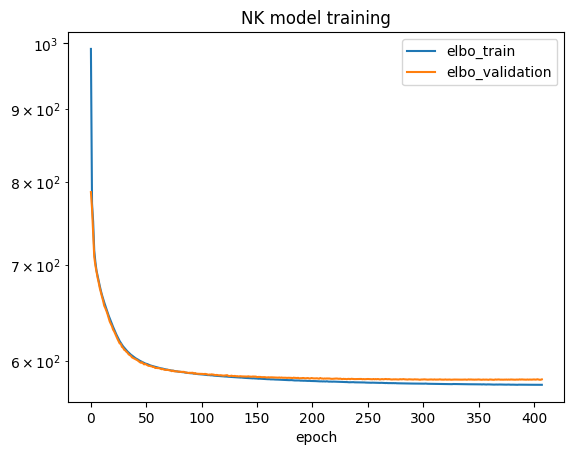

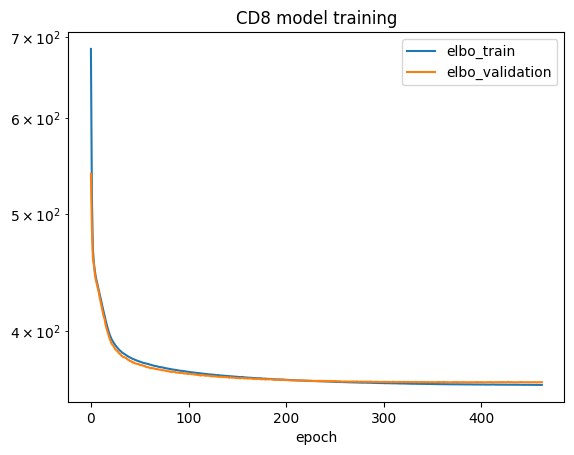

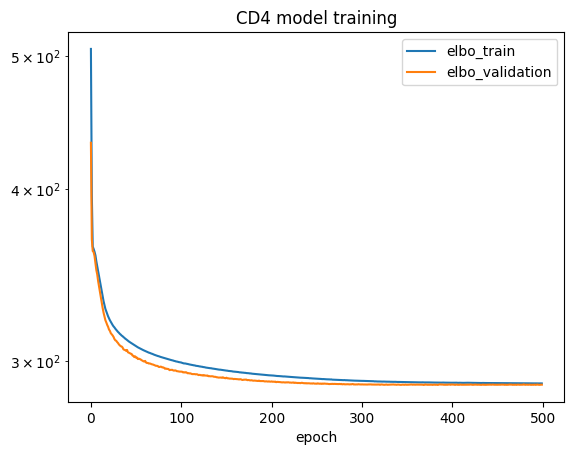

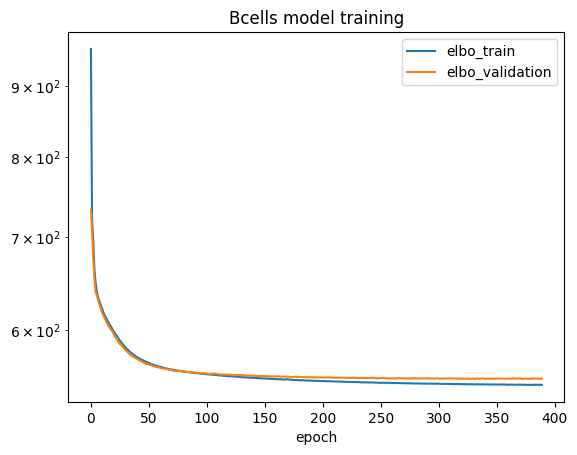

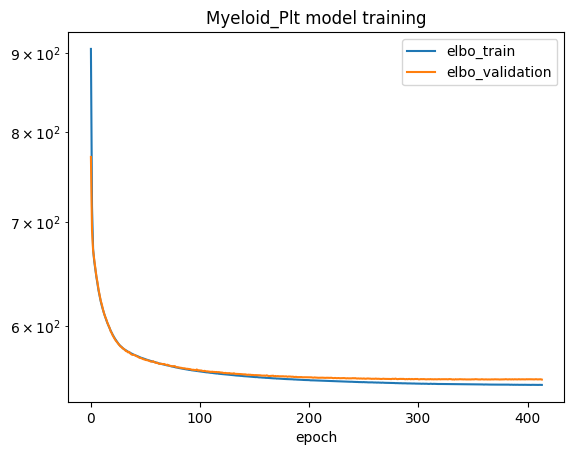

In [13]:
for name, value in vae_list.items():
    #plot training
    train_test_results = vae_list[name].history['elbo_train']
    train_test_results['elbo_validation'] = vae_list[name].history['elbo_validation']
    train_test_results.plot(logy=True)
    plt.title(name+" model training")
    plt.show()

In [15]:
for name, value in adata_list.items():
    print('generating latent space for '+name)
    adata_list[name].obsm["X_scvi"] = vae_list[name].get_latent_representation()
    
    print('generating neighbours for '+name)
    sc.pp.neighbors(adata_list[name], use_rep="X_scvi", n_neighbors=30)
    
    print('generating umap for '+name)
    sc.tl.umap(adata_list[name], min_dist = 0.5, spread = 2)
    
    print('normalising data for '+name)
    #del adata_list[name].uns["log1p"]
    #adata_list[name].X = adata_list[name].layers["counts"].copy()
    sc.pp.normalize_total(adata_list[name], target_sum=1e4)
    sc.pp.log1p(adata_list[name])

generating latent space for NK
generating neighbours for NK
generating umap for NK
normalising data for NK
generating latent space for CD8
generating neighbours for CD8
generating umap for CD8
normalising data for CD8
generating latent space for CD4
generating neighbours for CD4
generating umap for CD4
normalising data for CD4
generating latent space for Bcells
generating neighbours for Bcells
generating umap for Bcells
normalising data for Bcells
generating latent space for Myeloid_Plt
generating neighbours for Myeloid_Plt
generating umap for Myeloid_Plt
normalising data for Myeloid_Plt


plotting umap embedding for NK


/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


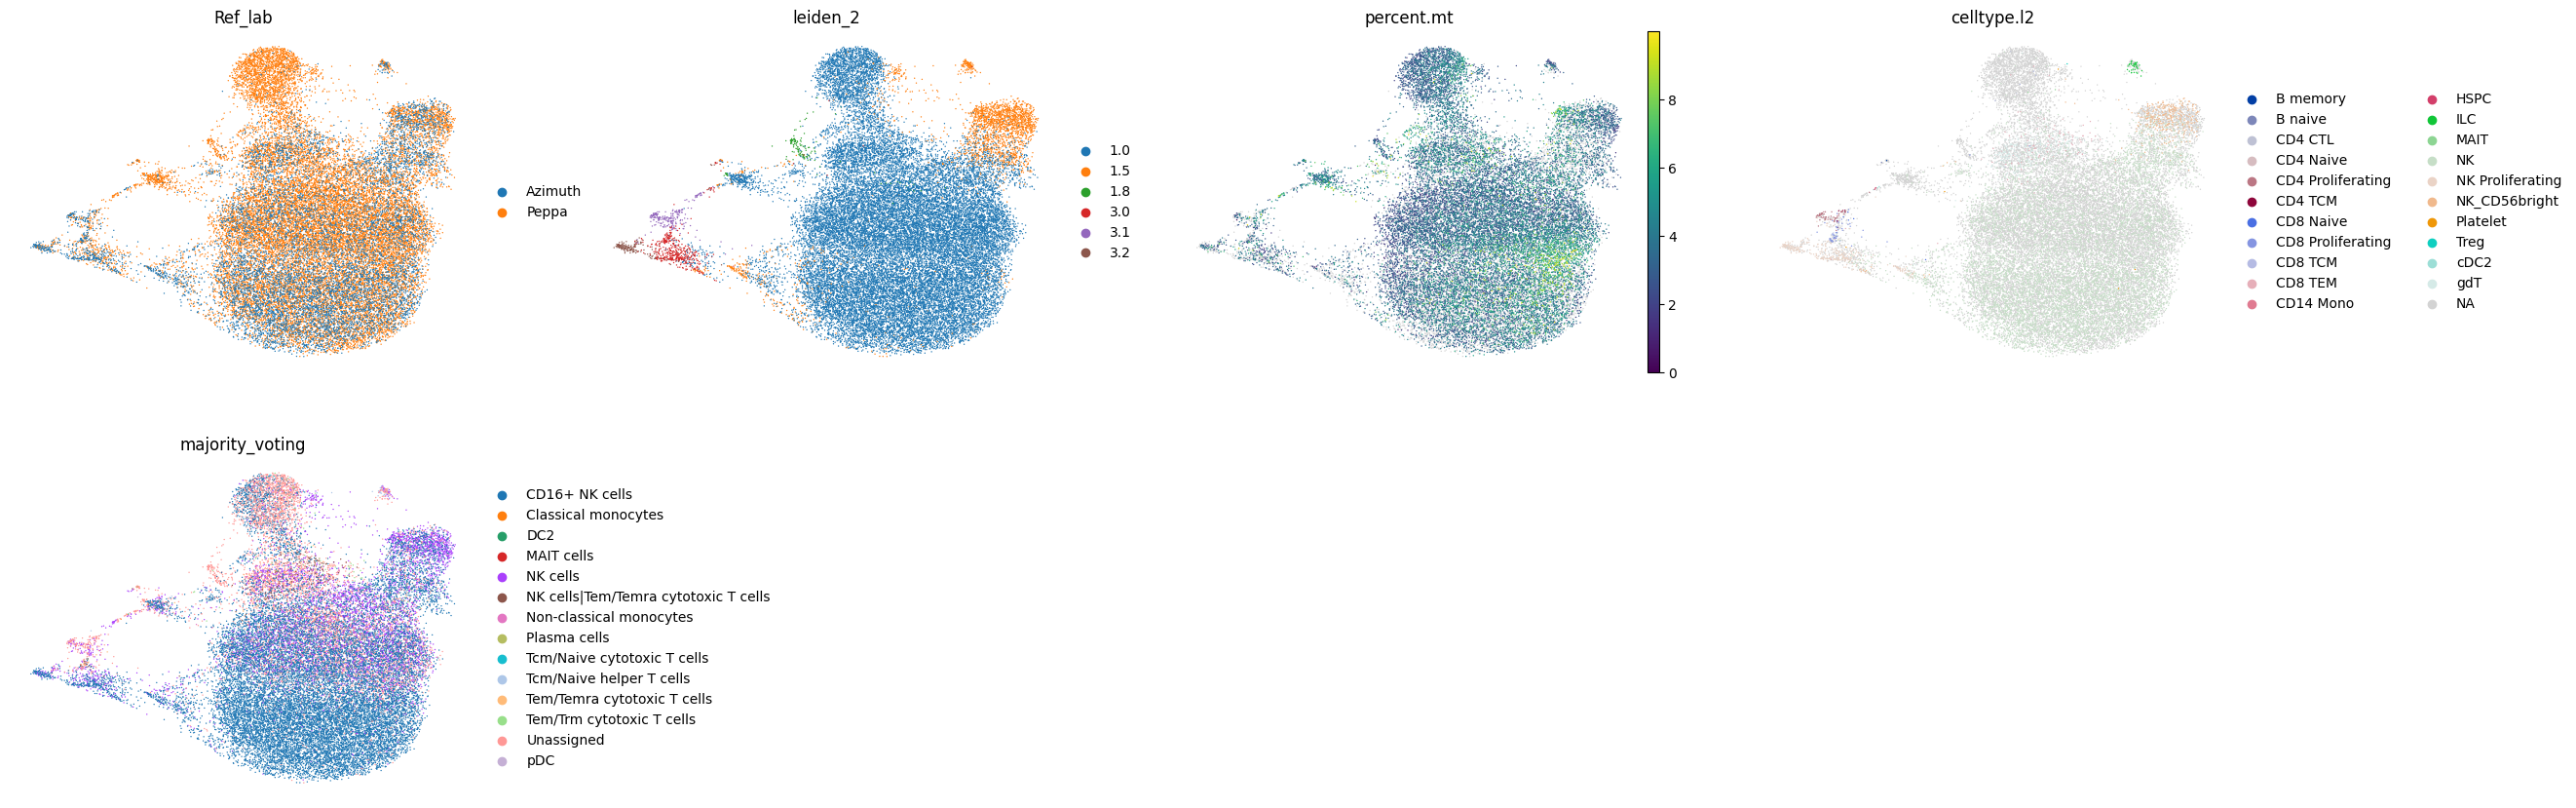

plotting umap embedding for CD8


/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 640x480 with 0 Axes>

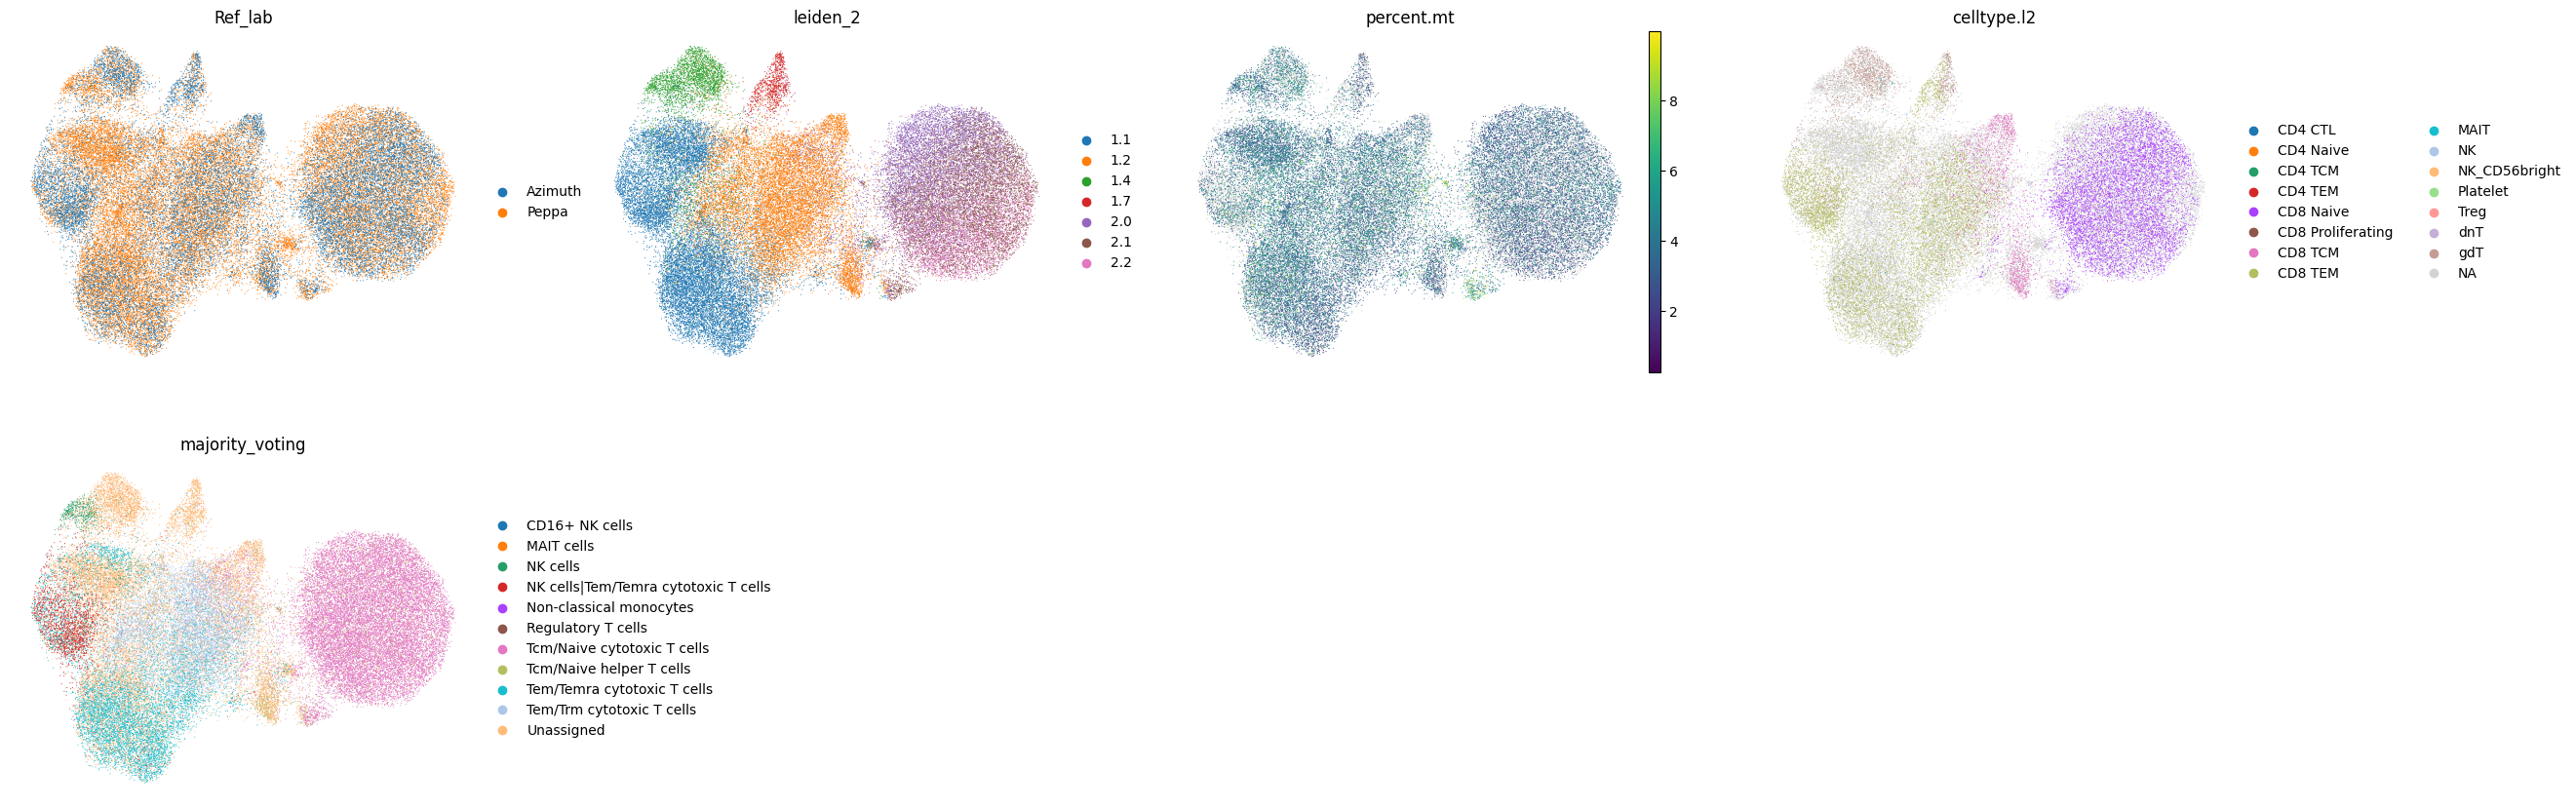

plotting umap embedding for CD4


/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 640x480 with 0 Axes>

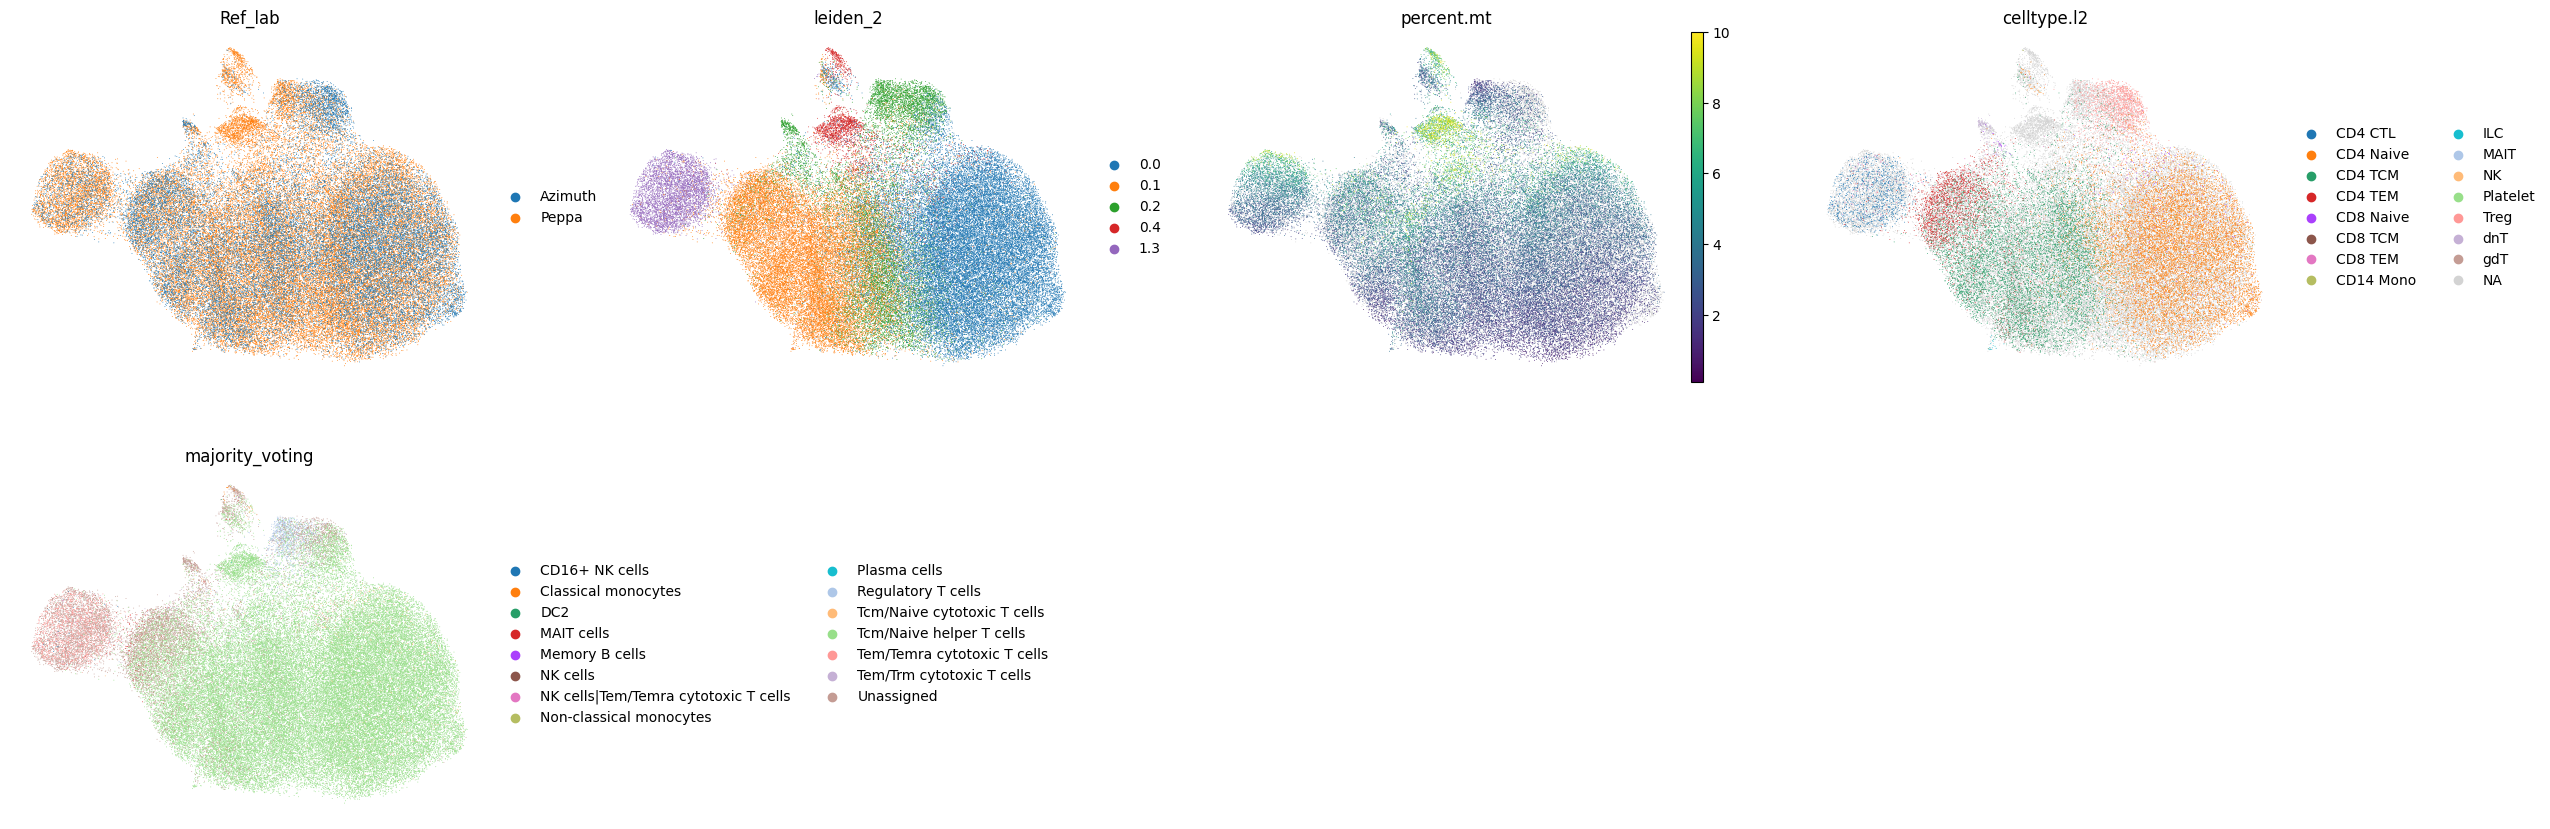

plotting umap embedding for Bcells


/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 640x480 with 0 Axes>

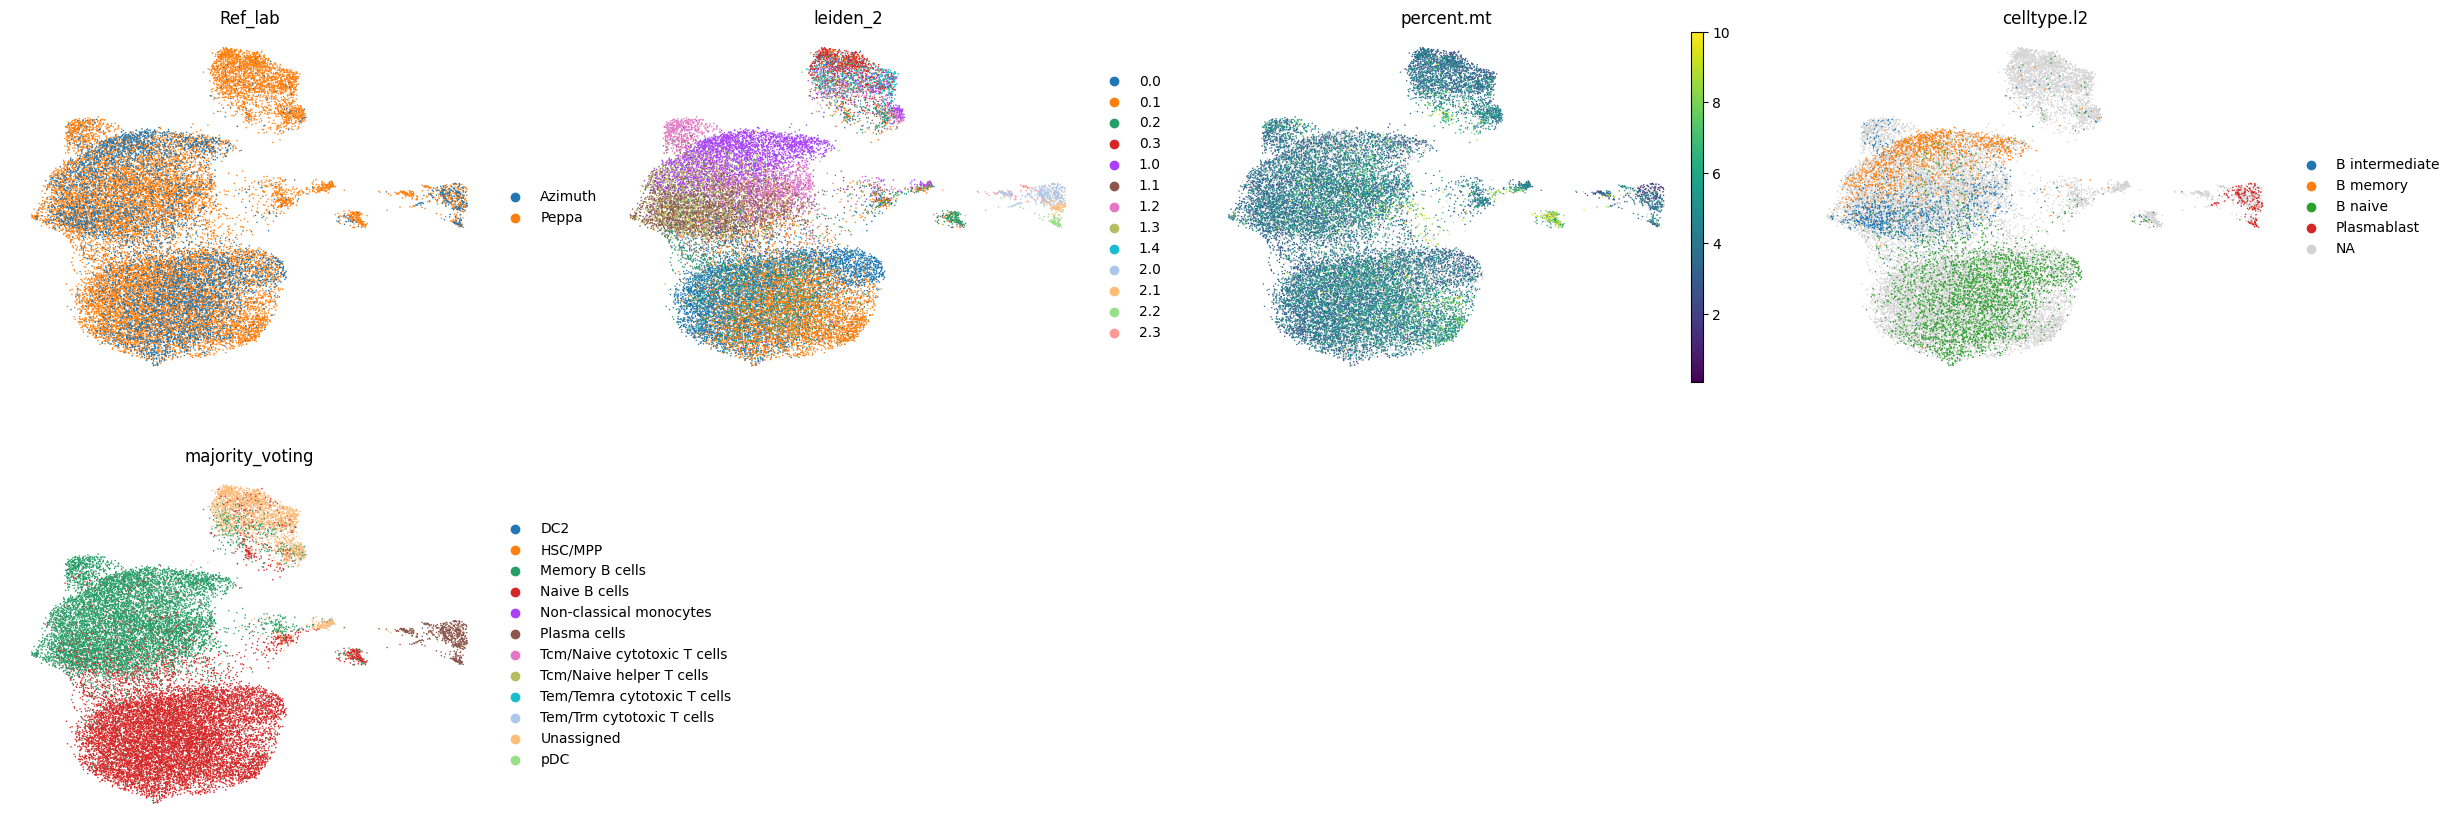

plotting umap embedding for Myeloid_Plt


/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 640x480 with 0 Axes>

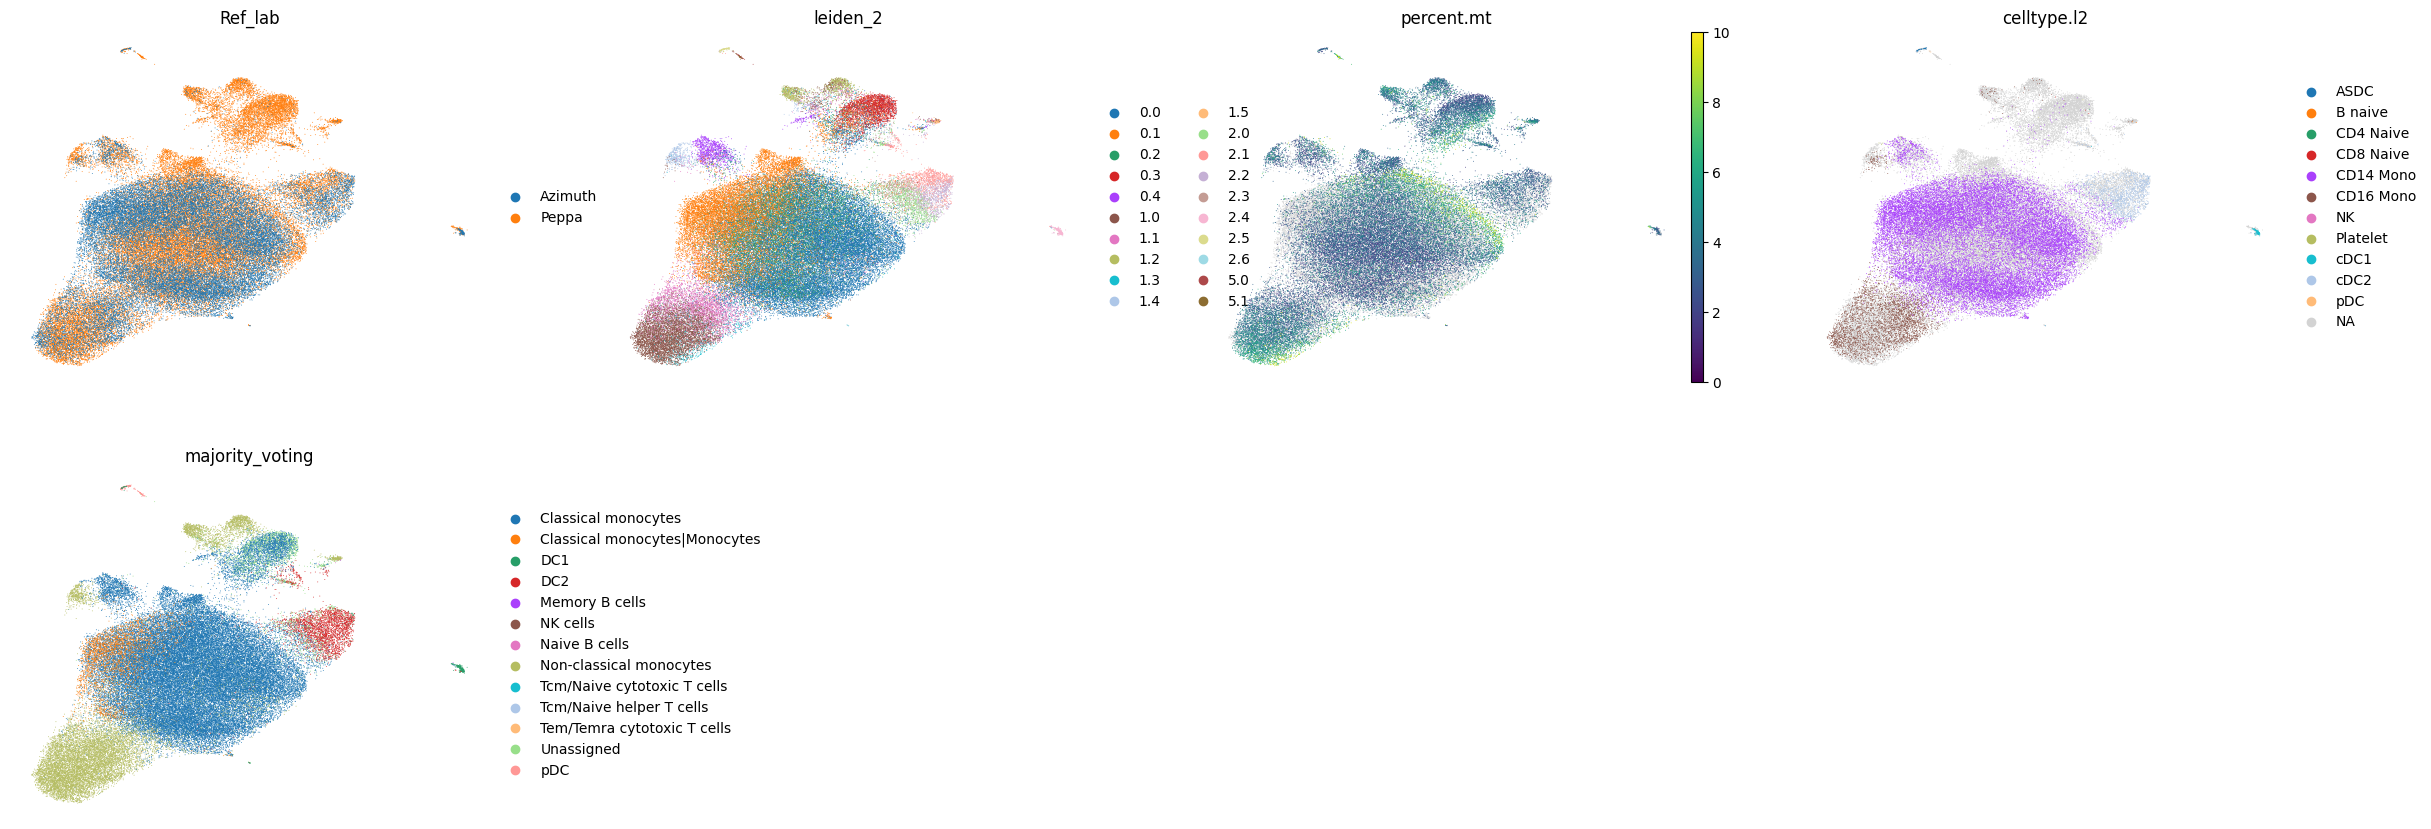

<Figure size 640x480 with 0 Axes>

In [16]:
for name, value in adata_list.items():
    print('plotting umap embedding for '+name)
    with plt.rc_context():
        sc.pl.umap(
            adata_list[name],
            color=["Ref_lab", "leiden_2","percent.mt", "celltype.l2", "majority_voting"],
            frameon=False,
            #ncols=1,
        )
        plt.savefig(plot_dir+name+"_model_umap.png", bbox_inches="tight", dpi=300)


/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


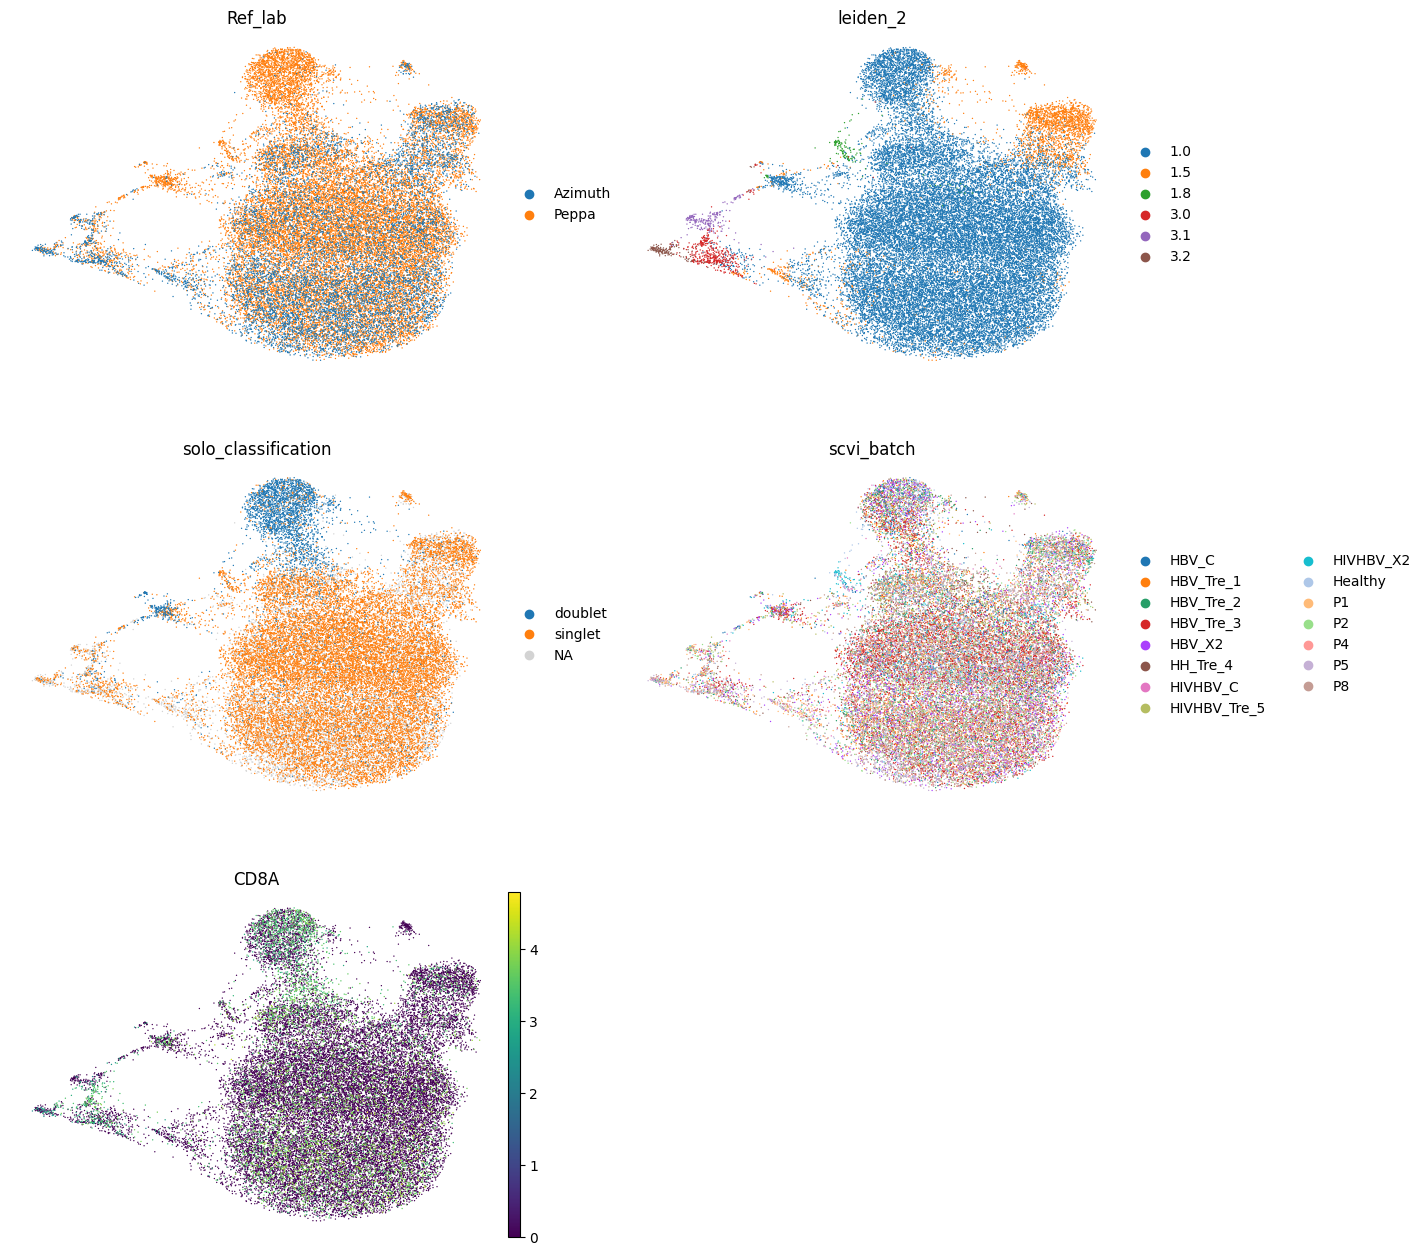

In [17]:
sc.pl.umap(
    adata_list["NK"],
    color=["Ref_lab", "leiden_2", "solo_classification", "scvi_batch", "CD8A"],
    frameon=False,
    ncols=2,
    #legend_loc='on data',
)

/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


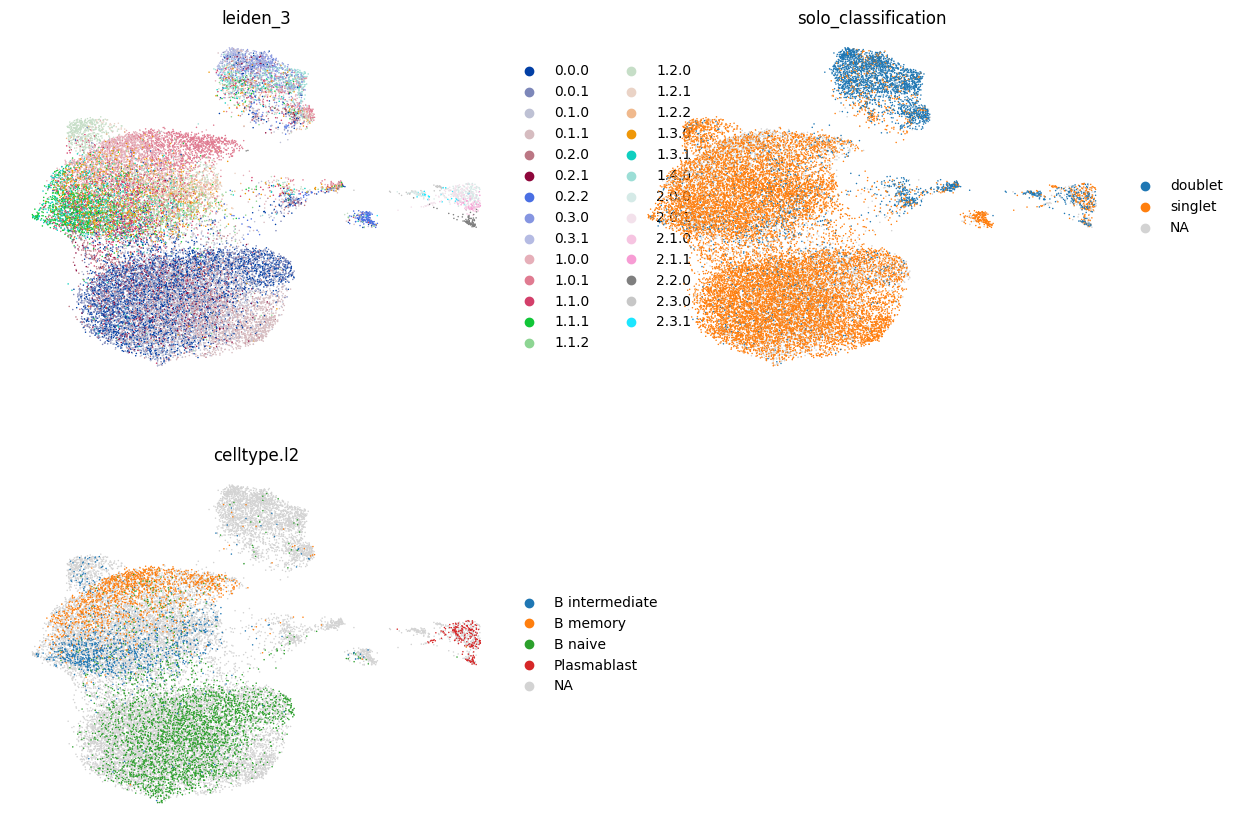

In [18]:
sc.pl.umap(
    adata_list["Bcells"],
    color=["leiden_3","solo_classification","celltype.l2"],
    frameon=False,
    ncols=2,
    #legend_loc='on data',
)